1) Imports
Goal is to build as much from scratch as possible so only import pandas and numpy to read in and manipulate data.


In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

2) Generate training data

For the purpose of this excercise we are using the "beloved" census dataset with our "beloved" 'is_above_50k' label

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:4: RuntimeWarning: covariance is not positive-semidefinite.


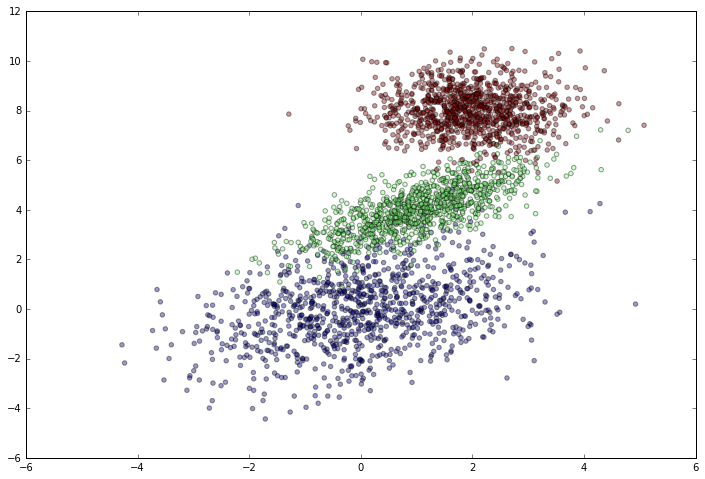

In [19]:
num_observations = 1000
x1 = np.random.multivariate_normal([0, 0], [[2, .75],[.75, 2]], num_observations)
x2 = np.random.multivariate_normal([1, 4], [[1, .75],[.75, 1]], num_observations)
x3 = np.random.multivariate_normal([2, 8], [[0, .75],[.75, 0]], num_observations)

simulated_separableish_features = np.vstack((x1, x2, x3)).astype(np.float32)
simulated_labels = np.hstack((np.zeros(num_observations), np.ones(num_observations), np.ones(num_observations) + 1))
%matplotlib inline
plt.figure(figsize=(12,8))
plt.scatter(simulated_separableish_features[:, 0], simulated_separableish_features[:, 1],
            c = simulated_labels, alpha = .4)


3) Split into train and validation sets

In [20]:
labels_onehot = np.zeros((simulated_labels.shape[0], 3)).astype(int)
labels_onehot[np.arange(len(simulated_labels)), simulated_labels.astype(int)] = 1

x_train, x_valid, y_train, y_valid = train_test_split(
    simulated_separableish_features, labels_onehot, test_size = .1, random_state = 12)

4) Initialize weight matrixes and bias matrixes.

We will be constructing a NN with 1 hidden layer, Relu activation functions, with a final layer of softmax.
We will use binary cross-entropy to calculate loss.

In [21]:
def stablesoftmax(x):
    """Compute the softmax of vector x in a numerically stable way."""
    shiftx = x - np.reshape(np.max(x, axis=1), (x.shape[0],1))
    exps = np.exp(shiftx)
    return exps / np.reshape(np.sum(exps, axis = 1), (x.shape[0], 1))

In [24]:
# Takes from input dimension to hidden layer 
W1 = np.random.rand(x_train.shape[1], 5)
b1 = np.random.rand(1, 5)

# Takes us from hidden layer to output layer
W2 = np.random.rand(5, 3)
b2 = np.random.rand(1, 3)

0.01
21.4463906496
0.4488


[2, 0, 2, 0, 0, 0, 0, 0, 0, 0]
0.01
8.46921104547
0.6875


[2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
0.01
8.46921104547
0.6875


[2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
0.01
8.46921104547
0.6875


[2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
0.01
8.46921104547
0.6875


[2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
0.01
8.46921104547
0.6875


[2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
0.01
8.46921104547
0.6875


[2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
0.01
8.46921104547
0.6875


[2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
0.01
8.46921104547
0.6875


[2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
0.01
8.50165004021
0.7029


[2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
0.01
8.38990281828
0.682


[2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
0.01
8.38990281828
0.682


[2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
0.01
8.38990281828
0.682


[2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
0.01
8.38990281828
0.682


[2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
0.01
8.38990281828
0.682


[2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
0.01
8.38990281828
0.682


[2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
0.01
8.38990281828
0.682


[2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
0.01

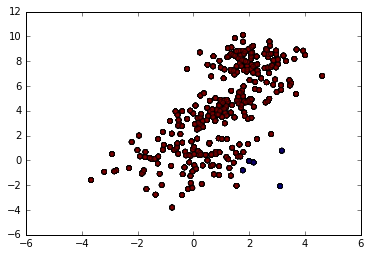

In [25]:
j = 0
lr = 0.01
for i in range(5000):
    if (j+1) * 3 > len(x_train):
        j = 0
    x = x_train[j*32:(j+1) * 32]
    y = y_train[j*32:(j+1) * 32]
    j += 1
    z1 = np.matmul(x, W1)
    #print z1
    rel1 = np.maximum(z1, 0)
    z2 = np.matmul(rel1, W2) 
    softmax = stablesoftmax(z2) 
    #print softmax > 0.5
    
    dLDz2 = (softmax - y) / 32.0
    #print dLDRelu2
    #dLDz2 = np.multiply(dLDRelu2, relu2_arr)
    dLDw2 = np.matmul(rel1.transpose(), dLDz2)
    dLRelu1 = np.matmul(dLDz2, W2.transpose())
    relu1_arr = np.array(z1 > 0, dtype=np.int32)
    dLDz1 = np.multiply(dLRelu1, relu1_arr)
    dLDw1 = np.matmul(x.transpose(), dLDz1 )      
    #print dLDw1    
    #print W1
    #print W2
    W2 = W2 - lr * dLDw2
    #print W2
    #b2 = b2 - lr * sum(dLDw2)
    #print W1
    W1 = W1 - lr * dLDw1
    #print W1
    #b1 = b1- lr * sum(dLDw1)
    
    
    
    z1 = np.matmul(x_valid, W1)
    #print z1
    rel1 = np.maximum(z1, 0)
    z2 = np.matmul(rel1, W2)
    #rel2 = np.maximum(z2, 0)
    softmax = stablesoftmax(z2)
    #print softmax
    logit_err = -np.sum(np.multiply(y_valid, np.log(softmax)))
    labels_pred = np.array(softmax > 0.5, dtype=np.int)
    if i % 100 == 0:
        print lr 
        print logit_err / 32
        print np.sum(np.sum(labels_pred == y_valid)) * 0.33 / len(y_valid)
        print "\n"
      
        labels_pred = [0 if v[0] == 1 else (1 if v[1] == 1 else 2) for v in labels_pred]
        print labels_pred[:10]
        if len(set(labels_pred)) > 0:
            plt.scatter(x_valid[:, 0], x_valid[:, 1],
                    c = labels_pred, alpha = .4)
    #print softmax > 0.5
    
   
    

In [326]:
print W1

[[ 0.13682273  0.54369615]
 [ 0.70764001  0.47538089]]
